## M.orygis genome analysis

links:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647658/
* http://bacteria.ensembl.org/Mycobacterium_orygis_112400015/Info/Index
* https://www.frontiersin.org/articles/10.3389/fmicb.2018.02820/full
* https://www.ncbi.nlm.nih.gov/assembly/?term=mycobacterium+orygis
* https://www.ncbi.nlm.nih.gov/bioproject/PRJNA576656

refs:

* https://www.ncbi.nlm.nih.gov/pubmed/22469053
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5621560/
* https://jb.asm.org/content/187/18/6386

In [1]:
import os, sys, io, random, subprocess, glob
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import seaborn as sns
sns.set_context("talk")
import pylab as plt
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

In [ ]:
seqs=SeqIO.parse('../Morygis_hokkaido.fa','fasta')
new=[]
for s in seqs:   
    s.id=s.id.replace('.','_')
    s.seq = s.seq.upper()
    new.append(s)
#SeqIO.write(new,'myco_genomes/Morygis_hokkaido.fna',format='fasta')

## Orygis SRA data

In [2]:
sra = pd.read_csv('Morygis_SRA.csv')
cols=['BioProject','Run','Sample Name','Host']
sra.groupby(['BioProject','Center Name','geo_loc_name_country']).agg({'Run':np.size}).reset_index()
#sra.iloc[1]

,BioProject,Center Name,geo_loc_name_country,Run
0,PRJNA389109,NEW YORK STATE DEPARTMENT OF HEALTH,USA,8
1,PRJNA575883,THE PENNSYLVANIA STATE UNIVERSITY,Bangladesh,1
2,PRJNA575883,THE PENNSYLVANIA STATE UNIVERSITY,India,25
3,PRJNA576656,ICAR-INDIAN VETERINARY RESEARCH INSTITUTE,India,19


In [42]:
samples = pd.read_csv('orygis_samples.csv')
path='read_data'
ref='mtbdiff/data/MTB-H37Rv.fna'
for i,row in samples.iterrows():    
    if type(row.run) is str:
        print (row['name'],row.run)
        fname = '../read_data/%s.fastq' %row.run        
        cmd = '/local/SPAdes-3.13.0/bin/spades.py --only-assembler -1 {p}/{n}_1.fastq.gz -2 {p}/{n}_2.fastq.gz --careful -o {p}/{n} -t 15'.format(n=row.run,p=path)
        print (cmd)

Morygis_IK1351 SRR10251185
/local/SPAdes-3.13.0/bin/spades.py --only-assembler -1 read_data/SRR10251185_1.fastq.gz -2 read_data/SRR10251185_2.fastq.gz --careful -o read_data/SRR10251185 -t 15
Morygis_IK1664 SRR10251194
/local/SPAdes-3.13.0/bin/spades.py --only-assembler -1 read_data/SRR10251194_1.fastq.gz -2 read_data/SRR10251194_2.fastq.gz --careful -o read_data/SRR10251194 -t 15
Morygis_IK1660 SRR10251195
/local/SPAdes-3.13.0/bin/spades.py --only-assembler -1 read_data/SRR10251195_1.fastq.gz -2 read_data/SRR10251195_2.fastq.gz --careful -o read_data/SRR10251195 -t 15


In [4]:
def get_fastani(filename):
    import re
    df = pd.read_csv(filename,sep='\t',names=['query','ref','ident','x','y'])
    df['query'] = df['query'].apply(lambda x: re.split(r"[\./]+",x)[1])
    df['ref'] = df['ref'].apply(lambda x: re.split(r"[\./]+",x)[1])
    x = pd.pivot_table(df,index='query',values='ident',columns=['ref'])
    return x

In [6]:
filename='fastani.out.matrix'
#df = pd.read_csv(filename,sep='\t')


In [6]:
cmd = 'fastANI --ql reference.txt --rl query.txt -o fastani.out -t 12'
#subprocess.check_output(cmd,shell=True)
anim = get_fastani('fastani.out')
anim.to_csv('ani_matrix.csv')

## run nucdiff

In [33]:
reload(utils)
path = 'myco_genomes'
names = analysis.run_genomes(path, outpath='myco_results', options='--reloc_dist 30000')

myco_genomes/Morygis_Resp2008.fna Morygis_Resp2008
myco_genomes/Morygis_IK1664.fna Morygis_IK1664
myco_genomes/Mafricanum.fna Mafricanum
myco_genomes/Morygis_NIRTAH144.fna Morygis_NIRTAH144
myco_genomes/Mpinnipedii_MP2.fna Mpinnipedii_MP2
myco_genomes/Morygis_Resp2011.fna Morygis_Resp2011
myco_genomes/Mmicroti.fna Mmicroti
myco_genomes/Mmungi_BM22813.fna Mmungi_BM22813
myco_genomes/Mcaprae.fna Mcaprae
myco_genomes/Morygis_LN2011.fna Morygis_LN2011
myco_genomes/Morygis_hokkaido.fna Morygis_hokkaido
myco_genomes/Morygis_IK1351.fna Morygis_IK1351
myco_genomes/Mbovis.fna Mbovis
myco_genomes/Morygis_IK1660.fna Morygis_IK1660
myco_genomes/Mpinnipedii.fna Mpinnipedii
myco_genomes/Mcanettii.fna Mcanettii
myco_genomes/Morygis_112400015.fna Morygis_112400015
myco_genomes/BCG_Pasteur.fna BCG_Pasteur
myco_genomes/MTB_beijing.fna MTB_beijing
myco_genomes/Morygis_Absc2007.fna Morygis_Absc2007
myco_genomes/MTB_ethiopia.fna MTB_ethiopia


## get nucdiff results
* get RD regions
* get protein annotations

In [34]:
reload(utils)
print (names)

struct, snp =  utils.get_nucdiff_results('myco_results', names)
#struct = struct[(struct.Name=='deletion') | (struct.Name=='insertion')]
struct['RD'] = struct.apply(utils.get_region,1)

subcols = ['ID','Name','start','end','length','descr','RD']
print (struct[:4][subcols])


['Morygis_Resp2008', 'Morygis_IK1664', 'Mafricanum', 'Morygis_NIRTAH144', 'Mpinnipedii_MP2', 'Morygis_Resp2011', 'Mmicroti', 'Mmungi_BM22813', 'Mcaprae', 'Morygis_LN2011', 'Morygis_hokkaido', 'Morygis_IK1351', 'Mbovis', 'Morygis_IK1660', 'Mpinnipedii', 'Mcanettii', 'Morygis_112400015', 'BCG_Pasteur', 'MTB_beijing', 'Morygis_Absc2007', 'MTB_ethiopia']
       ID              Name  start    end  length                         descr RD
1  SV_100  collapsed_repeat  34787  34802      15  collapsed_repeat_34787:34802  -
2   SV_99          deletion  34802  35208     406          deletion_34802:35208  -
3   SV_97         insertion  38981  38982       1         insertion_38981:38982  -
4   SV_98       duplication  38981  38982       1       duplication_38981:38982  -


## presence/absence matrix of events

In [35]:
reload(utils)
rdmat = utils.RD_matrix(struct)
smat = utils.sites_matrix(struct, freq=5)
len(smat)

194

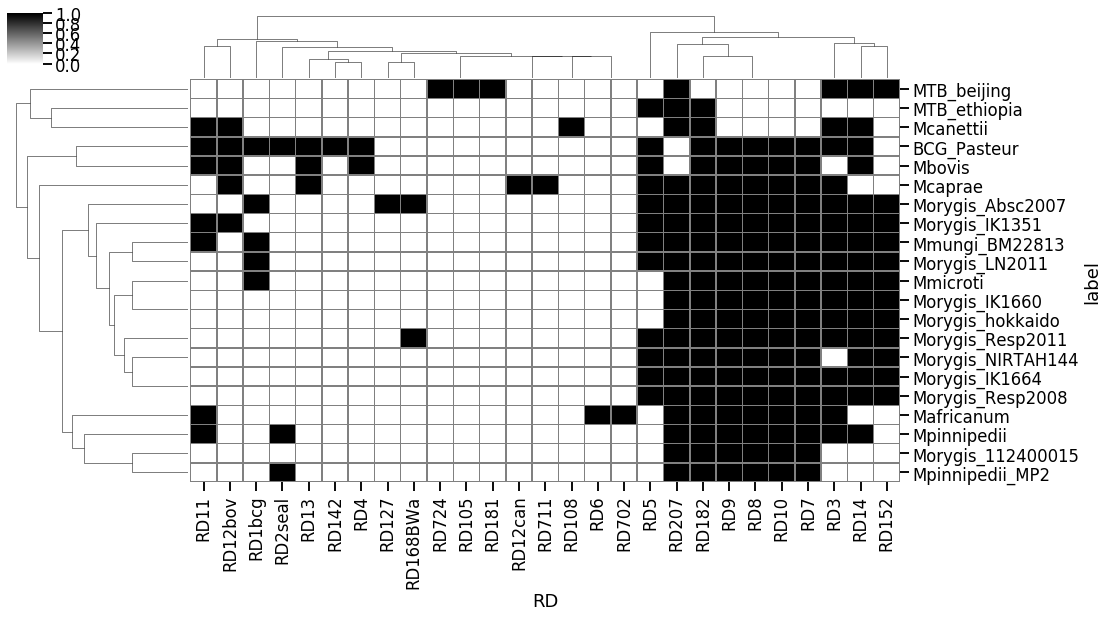

In [36]:
#x=run_RD_checker(rds)
fig = analysis.plot_RD(rdmat.T)
fig.savefig('RD_matrix.png',dpi=150)

In [ ]:
reload(analysis)
fig = analysis.plot_RD(smat.T,lw=0)
fig.savefig('orygis_sites.png',dpi=150)

## summary

656


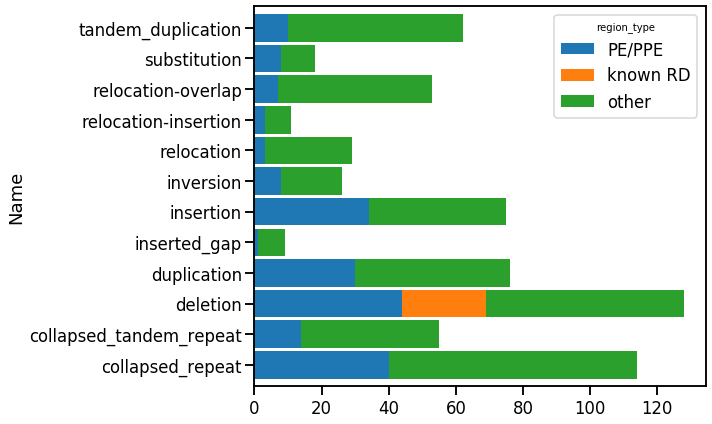

In [37]:
summ=utils.get_summary(struct)
summ
def plot_summary(df):
    s = pd.pivot_table(df,index=['Name'],values=['freq'],columns=['region_type'],aggfunc='count')
    s.columns = s.columns.get_level_values(1)
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    s.plot(kind='barh',stacked=True,width=.9,ax=ax)
    plt.tight_layout()
    fig.savefig('struct_stats.png',dpi=150)
    
print (len(summ))
plot_summary(summ)

## Compare struct changes between mbovis and orygis 

* get common start sites between the orygis and bovis samples
* common snps?

414


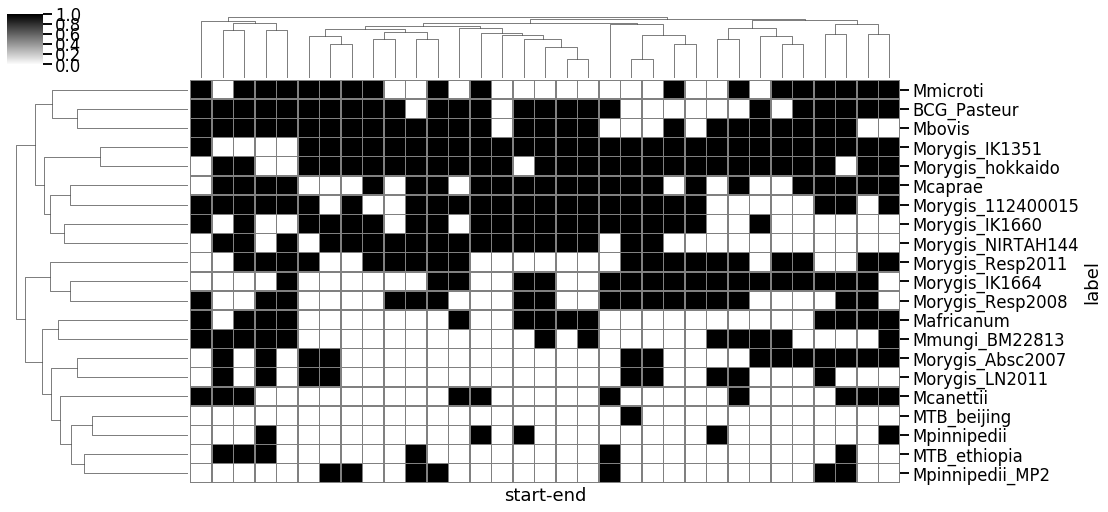

In [38]:
# changes in bovis and orygis but not in others

struct['orygis'] = struct.label.str.contains('Morygis').astype(int)
struct['bovis'] = struct.label.str.contains('Mbovis|caprae').astype(int)
struct['orygis_freq'] = struct.groupby(['descr'])['orygis'].transform(np.sum)
struct['bovis_freq'] = struct.groupby(['descr'])['bovis'].transform(np.sum)
struct['freq'] = struct.groupby(['descr'])['start'].transform(np.size)

so = struct[(struct.orygis_freq>=5) & (struct.freq<=13) & (struct.bovis_freq>=1)]
print (len(so))
so.label.value_counts()
so.descr.unique()
s = utils.get_summary(so)
s.to_csv('oryis_bovis_common.csv',index=False)
m = utils.sites_matrix(so, freq=0)
fig = analysis.plot_RD(m.T)
fig.savefig('orygis_mbovis_sites.svg')

29


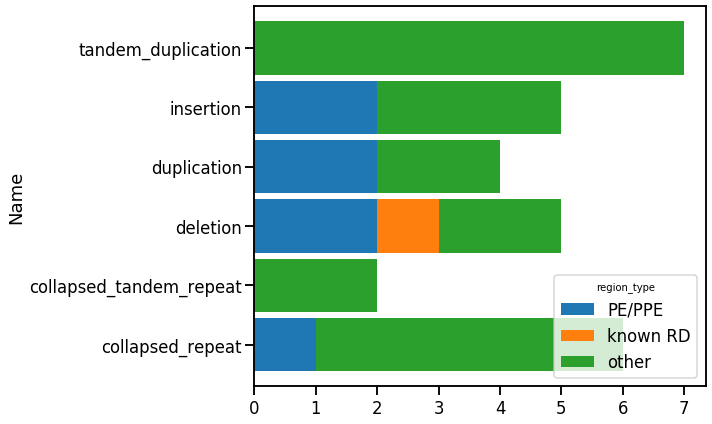

In [36]:
plot_summary(s)
print (len(s))

In [ ]:
summ[summ.Name=='relocation']

## known snps in orygis

In [40]:
reload(utils)
snp_summ = utils.get_summary(snp)

In [41]:
genes=['gyrB','Rv2042c','mmpL6']
snp_summ[snp_summ.gene.isin(genes)]

,start,end,Name,descr,ref_bases,query_bases,freq,length,RD,gene,region_type
49,6445,6446,substitution,substitution_6445:6446,G,T,18,1,-,gyrB,other
22451,2288568,2288569,substitution,substitution_2288568:2288569,A,C,10,1,-,Rv2042c,other
41,5515,5516,substitution,substitution_5515:5516,A,G,10,1,-,gyrB,other
46,6108,6109,substitution,substitution_6108:6109,G,A,10,1,-,gyrB,other
51,6716,6717,substitution,substitution_6716:6717,T,C,10,1,-,gyrB,other
44,5751,5752,substitution,substitution_5751:5752,G,A,3,1,-,gyrB,other
48,6405,6406,substitution,substitution_6405:6406,C,T,2,1,-,gyrB,other


## align orygis reads to H37Rv to check RDs missing?

In [24]:
def align_reads(file1, file2, idx, out):
    """align reads to ref"""

    cmd = 'bwa mem -M -t 8 %s %s %s | samtools sort | samtools view -bS - > %s' %(idx,file1,file1,out)   
    print (cmd )
    if not os.path.exists(out):        
        subprocess.check_output(cmd, shell=True)        
    return

def get_unmapped(bam_file):
    cmd = 'samtools view -b -f 4 file.bam > unmapped.bam'
    return
    

In [25]:
align_reads('../read_data/SRR10251185_1.fastq.gz','../read_data/SRR10251185_2.fastq.gz','MTB-H37Rv.fna', 'mapped/SRR10251185.bam')

bwa mem -M -t 8 MTB-H37Rv.fna ../read_data/SRR10251185_1.fastq.gz ../read_data/SRR10251185_1.fastq.gz | samtools sort | samtools view -bS - > mapped/SRR10251185.bam


In [27]:
cmd = 'bwa mem -M -t 8 MTB-H37Rv.fna myco_genomes/Morygis_IK1351.fna |  samtools sort | samtools view -bS - > mapped/Morygis_IK1351.bam'

In [34]:
def filter_contigs(filename,l=200):
    """filter contigs by length"""
    
    seqs=list(SeqIO.parse(filename, 'fasta'))
    new=[]
    for s in seqs:
        if len(s.seq)>=l:
            new.append(s)
    name=os.path.splitext(filename)[0]
    SeqIO.write(new, '%s_new.fna' %name,'fasta')
    return

filter_contigs('myco_genomes/Morygis_IK1351.fna')
                